In [7]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from rich import print
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
import matplotlib.pyplot as plt

print("[bold green]Libraries Imported: Pandas, Numpy, GeoPandas, Rich, MatPlotLib.[/bold green]")

Libraries Imported: Pandas, Numpy, GeoPandas, Rich, MatPlotLib.

In [ ]:
# All paths

apd_csv = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v3/cleaned_full_atl_v3.csv"
census_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/census_boundary_2024/cb_2024_13_place_500k.shp"
campus_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/area_landmark_2024/tl_2023_13_arealm.shp"
og_nhood_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_neighborhood/Official_Neighborhoods_-_Open_Data.shp"

# Loading data

df = pd.read_csv(apd_csv)
print("[bold yellow]Loading data points...[/bold yellow]")
gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
    crs="EPSG:4326"
)

print("[bold green]Loaded[/bold green]", len(gdf_points),"[bold green]points.[/bold green]")

cities = gpd.read_file(census_shp)
campuses = gpd.read_file(campus_shp)
neighborhoods = gpd.read_file(og_nhood_shp)
print("[bold green]Shapefiles loaded.[/bold green]")

Loading data points...

Loaded 19120 points.

Shapefiles loaded.

In [10]:
target_crs = cities.crs
print("[bold yellow]Aligning all crs...[/bold yellow]")

gdf_points = gdf_points.to_crs(target_crs)
campuses = campuses.to_crs(target_crs)
neighborhoods = neighborhoods.to_crs(target_crs)
print("[bold green]CRS aligned.[/bold green]")

Aligning all crs...

CRS aligned.

In [11]:
# Preparing to join layers
print("[bold yellow]Preparing to join layers...[/bold yellow]")
# Layer 1: Campuses
campuses_join = campuses[campuses['MTFCC'] == 'S1400'][['FULLNAME', 'geometry']]
campuses_join = campuses_join.rename(columns={'FULLNAME': 'campus_label'})

# Layer 2: Neighborhoods
neighborhoods_join = neighborhoods[['NAME', 'geometry']]
neighborhoods_join = neighborhoods_join.rename(columns={'NAME': 'neighborhood_label'})

# Layer 3: Cities
cities_join = cities[['NAME', 'geometry']]
cities_join = cities_join.rename(columns={'NAME': 'city_label'})
print("[bold green]Layers ready to join.[/bold green]")

print("[bold yellow]Joining all layers now...[/bold yellow]")

# Join 1: Campuses
joined_df = gpd.sjoin(gdf_points, campuses_join, how="left", predicate="within")

# Join 2: Neighborhoods
joined_df = joined_df.drop('index_right', axis=1, errors='ignore')
joined_df = gpd.sjoin(joined_df, neighborhoods_join, how="left", predicate="within")

# Join 3: Cities
joined_df = joined_df.drop('index_right', axis=1, errors='ignore')
joined_df = gpd.sjoin(joined_df, cities_join, how="left", predicate="within")

print("[bold green]Spatial joins complete![/bold green]")


Preparing to join layers...

Layers ready to join.

Joining all layers now...

Spatial joins complete!

In [12]:
# We create one final column, prioritizing the most granular label
print("Creating final 'location_label' feature...")

conditions = [
    joined_df['campus_label'].notna(),       # Priority 1: Campus
    joined_df['neighborhood_label'].notna(), # Priority 2: Neighborhood
    joined_df['city_label'].notna()          # Priority 3: City
]
choices = [
    joined_df['campus_label'],
    joined_df['neighborhood_label'],
    joined_df['city_label']
]

# Create the new column, defaulting to 'Other' if no match
joined_df['location_label'] = np.select(conditions, choices, default='Other')

# --- 8. CLEAN UP & SAVE FINAL CSV ---
print("Cleaning up final DataFrame...")
# Drop the intermediate helper columns
final_df = joined_df.drop(
    columns=['index_right', 'campus_label', 'neighborhood_label', 'city_label'], 
    errors='ignore'
)

# Convert the GeoDataFrame back to a regular DataFrame for saving
# (This drops the 'geometry' column which is bulky and not needed in the CSV)
final_csv_df = pd.DataFrame(final_df.drop(columns='geometry'))

# Save the new, clean CSV file!
OUTPUT = '/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v5/cleaned_full_atl_v5.csv'
final_csv_df.to_csv(OUTPUT, index=False)


print(f"Saved new file to: {OUTPUT}")

# --- 9. REVIEW YOUR NEW FEATURE ---
print("\nTop 50 locations from your new 'location_label' column:")
print(final_csv_df['location_label'].value_counts().head(50))

Creating final 'location_label' feature...

Cleaning up final DataFrame...

Saved new file to: 
/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v5/cleaned_full_atl_v5.csv

Top 50 locations from your new 'location_label' column:

location_label
Midtown                   1203
Downtown                  1091
College Park               805
Old Fourth Ward            683
Atlanta                    621
West End                   432
Oakland City               358
English Avenue             339
Lakewood Heights           333
Pittsburgh                 301
Sweet Auburn               288
Lindbergh/Morosgo          286
Grove Park                 278
Marietta Street Artery     266
Grant Park                 264
Other                      262
Reynoldstown               238
North Buckhead             234
East Atlanta               225
Campbellton Road           224
Lindridge/Martin Manor     215
Sylvan Hills               210
Edgewood                   197
Southwest                  194
Venetian Hills             192
Virginia Highland          191
Greenbriar                 191
Vine City                  188
Inman Park                 187
Mechanicsville             178
Collier Heights            176
Morningside/Lenox Park     175
Adamsville                 174
Kirkwood                   170
Atlantic Station           157
Harland Terrace            150
Home Park                  147
Piedmont Heights           144
Peoplestown                144
Perkerson                  144
Castleberry Hill           142
Pine Hills                 136
Glenrose Heights           133
Hammond Park               129
South River Gardens        129
Poncey-Highland            126
Adair Park                 125
Berkeley Park              124
East Lake                  121
Center Hill                119
Name: count, dtype: int64

In [4]:
import pandas as pd

# Load the final, cleaned file you just saved
final_df = pd.read_csv('/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v5/cleaned_full_atl_v5.csv')

# 1. Check your old, broken column
print("--- Old 'NhoodName' Column ---")
print(final_df['NhoodName'].value_counts(dropna=False).head(10))

# 2. Check your new, fixed column
print("\n--- New 'location_label' Column ---")
print(final_df['location_label'].value_counts().head(20))

# 3. Check the "Other" count
other_count = (final_df['location_label'] == 'Other').sum()
print(f"\nRows that failed all 3 joins (should be low): {other_count}")

--- Old 'NhoodName' Column ---
NhoodName
NaN                 1738
Midtown             1203
Downtown            1091
Old Fourth Ward      683
West End             432
Oakland City         358
English Avenue       339
Lakewood Heights     333
Home Park            304
Pittsburgh           301
Name: count, dtype: int64

--- New 'location_label' Column ---
location_label
Midtown                   1203
Downtown                  1091
College Park               805
Old Fourth Ward            683
Atlanta                    621
West End                   432
Oakland City               358
English Avenue             339
Lakewood Heights           333
Pittsburgh                 301
Sweet Auburn               288
Lindbergh/Morosgo          286
Grove Park                 278
Marietta Street Artery     266
Grant Park                 264
Other                      262
Reynoldstown               238
North Buckhead             234
East Atlanta               225
Campbellton Road           224
Name: count

262 had no match, marked as other. May be highway, cemetary, etc?

In [13]:
import pandas as pd
from rich.console import Console
from rich.table import Table

# --- 1. Load your CSV ---
csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v5/cleaned_full_atl_v5.csv"
try:
    final_df = pd.read_csv(csv_path)
    # --- 2. Get the value counts ---
    location_counts = final_df['location_label'].value_counts()

    # --- 3. Create a Rich Table ---
    table = Table(title="Location Label Value Counts", show_header=True, header_style="bold magenta")
    table.add_column("Location Label", style="dim", width=40)
    table.add_column("Count", justify="right")

    # --- 4. Add data to the table ---
    for location, count in location_counts.items():
        table.add_row(location, str(count))

    # --- 5. Print the table ---
    console = Console()
    console.print(table)

except FileNotFoundError:
    print(f"Error: File not found at {csv_path}")
except Exception as e:
    print(f"An error occurred: {e}")

            Location Label Value Counts             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Location Label                           ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Midtown                                  │  1203 │
│ Downtown                                 │  1091 │
│ College Park                             │   805 │
│ Old Fourth Ward                          │   683 │
│ Atlanta                                  │   621 │
│ West End                                 │   432 │
│ Oakland City                             │   358 │
│ English Avenue                           │   339 │
│ Lakewood Heights                         │   333 │
│ Pittsburgh                               │   301 │
│ Sweet Auburn                             │   288 │
│ Lindbergh/Morosgo                        │   286 │
│ Grove Park                               │   278 │
│ Marietta Street Artery                   │   266 │
│ Grant Park                               │   264 │
│ Other                                    │   262 │
│ Reynoldstown                             │   238 │
│ North Buckhead                           │   234 │
│ East Atlanta                             │   225 │
│ Campbellton Road                         │   224 │
│ Lindridge/Martin Manor                   │   215 │
│ Sylvan Hills                             │   210 │
│ Edgewood                                 │   197 │
│ Southwest                                │   194 │
│ Venetian Hills                           │   192 │
│ Virginia Highland                        │   191 │
│ Greenbriar                               │   191 │
│ Vine City                                │   188 │
│ Inman Park                               │   187 │
│ Mechanicsville                           │   178 │
│ Collier Heights                          │   176 │
│ Morningside/Lenox Park                   │   175 │
│ Adamsville                               │   174 │
│ Kirkwood                                 │   170 │
│ Atlantic Station                         │   157 │
│ Harland Terrace                          │   150 │
│ Home Park                                │   147 │
│ Piedmont Heights                         │   144 │
│ Peoplestown                              │   144 │
│ Perkerson                                │   144 │
│ Castleberry Hill                         │   142 │
│ Pine Hills                               │   136 │
│ Glenrose Heights                         │   133 │
│ Hammond Park                             │   129 │
│ South River Gardens                      │   129 │
│ Poncey-Highland                          │   126 │
│ Adair Park                               │   125 │
│ Berkeley Park                            │   124 │
│ East Lake                                │   121 │
│ Center Hill                              │   119 │
│ Loring Heights                           │   115 │
│ Adams Park                               │   114 │
│ Lenox                                    │   111 │
│ Princeton Lakes                          │   106 │
│ Fairburn Mays                            │   102 │
│ South Atlanta                            │   102 │
│ Dixie Hills                              │    99 │
│ Cascade Avenue/Road                      │    99 │
│ Westview                                 │    98 │
│ Summerhill                               │    96 │
│ Ashview Heights                          │    94 │
│ South Tuxedo Park                        │    94 │
│ Ormewood Park                            │    93 │
│ Browns Mill Park                         │    90 │
│ Underwood Hills                          │    89 │
│ Bolton                                   │    87 │
│ Blandtown                                │    87 │
│ Riverside                                │    85 │
│ Buckhead Village                         │    84 │
│ Capitol View                             │    83 │
│ Florida Heights                          │    80 │
│ Custer/McDonough/Guice 

In [17]:
%pip install adjustText

Note: you may need to restart the kernel to use updated packages.


Creating cleaner validation map...
Adjusting labels...


/tmp/ipykernel_117198/2635065571.py:75: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper left')


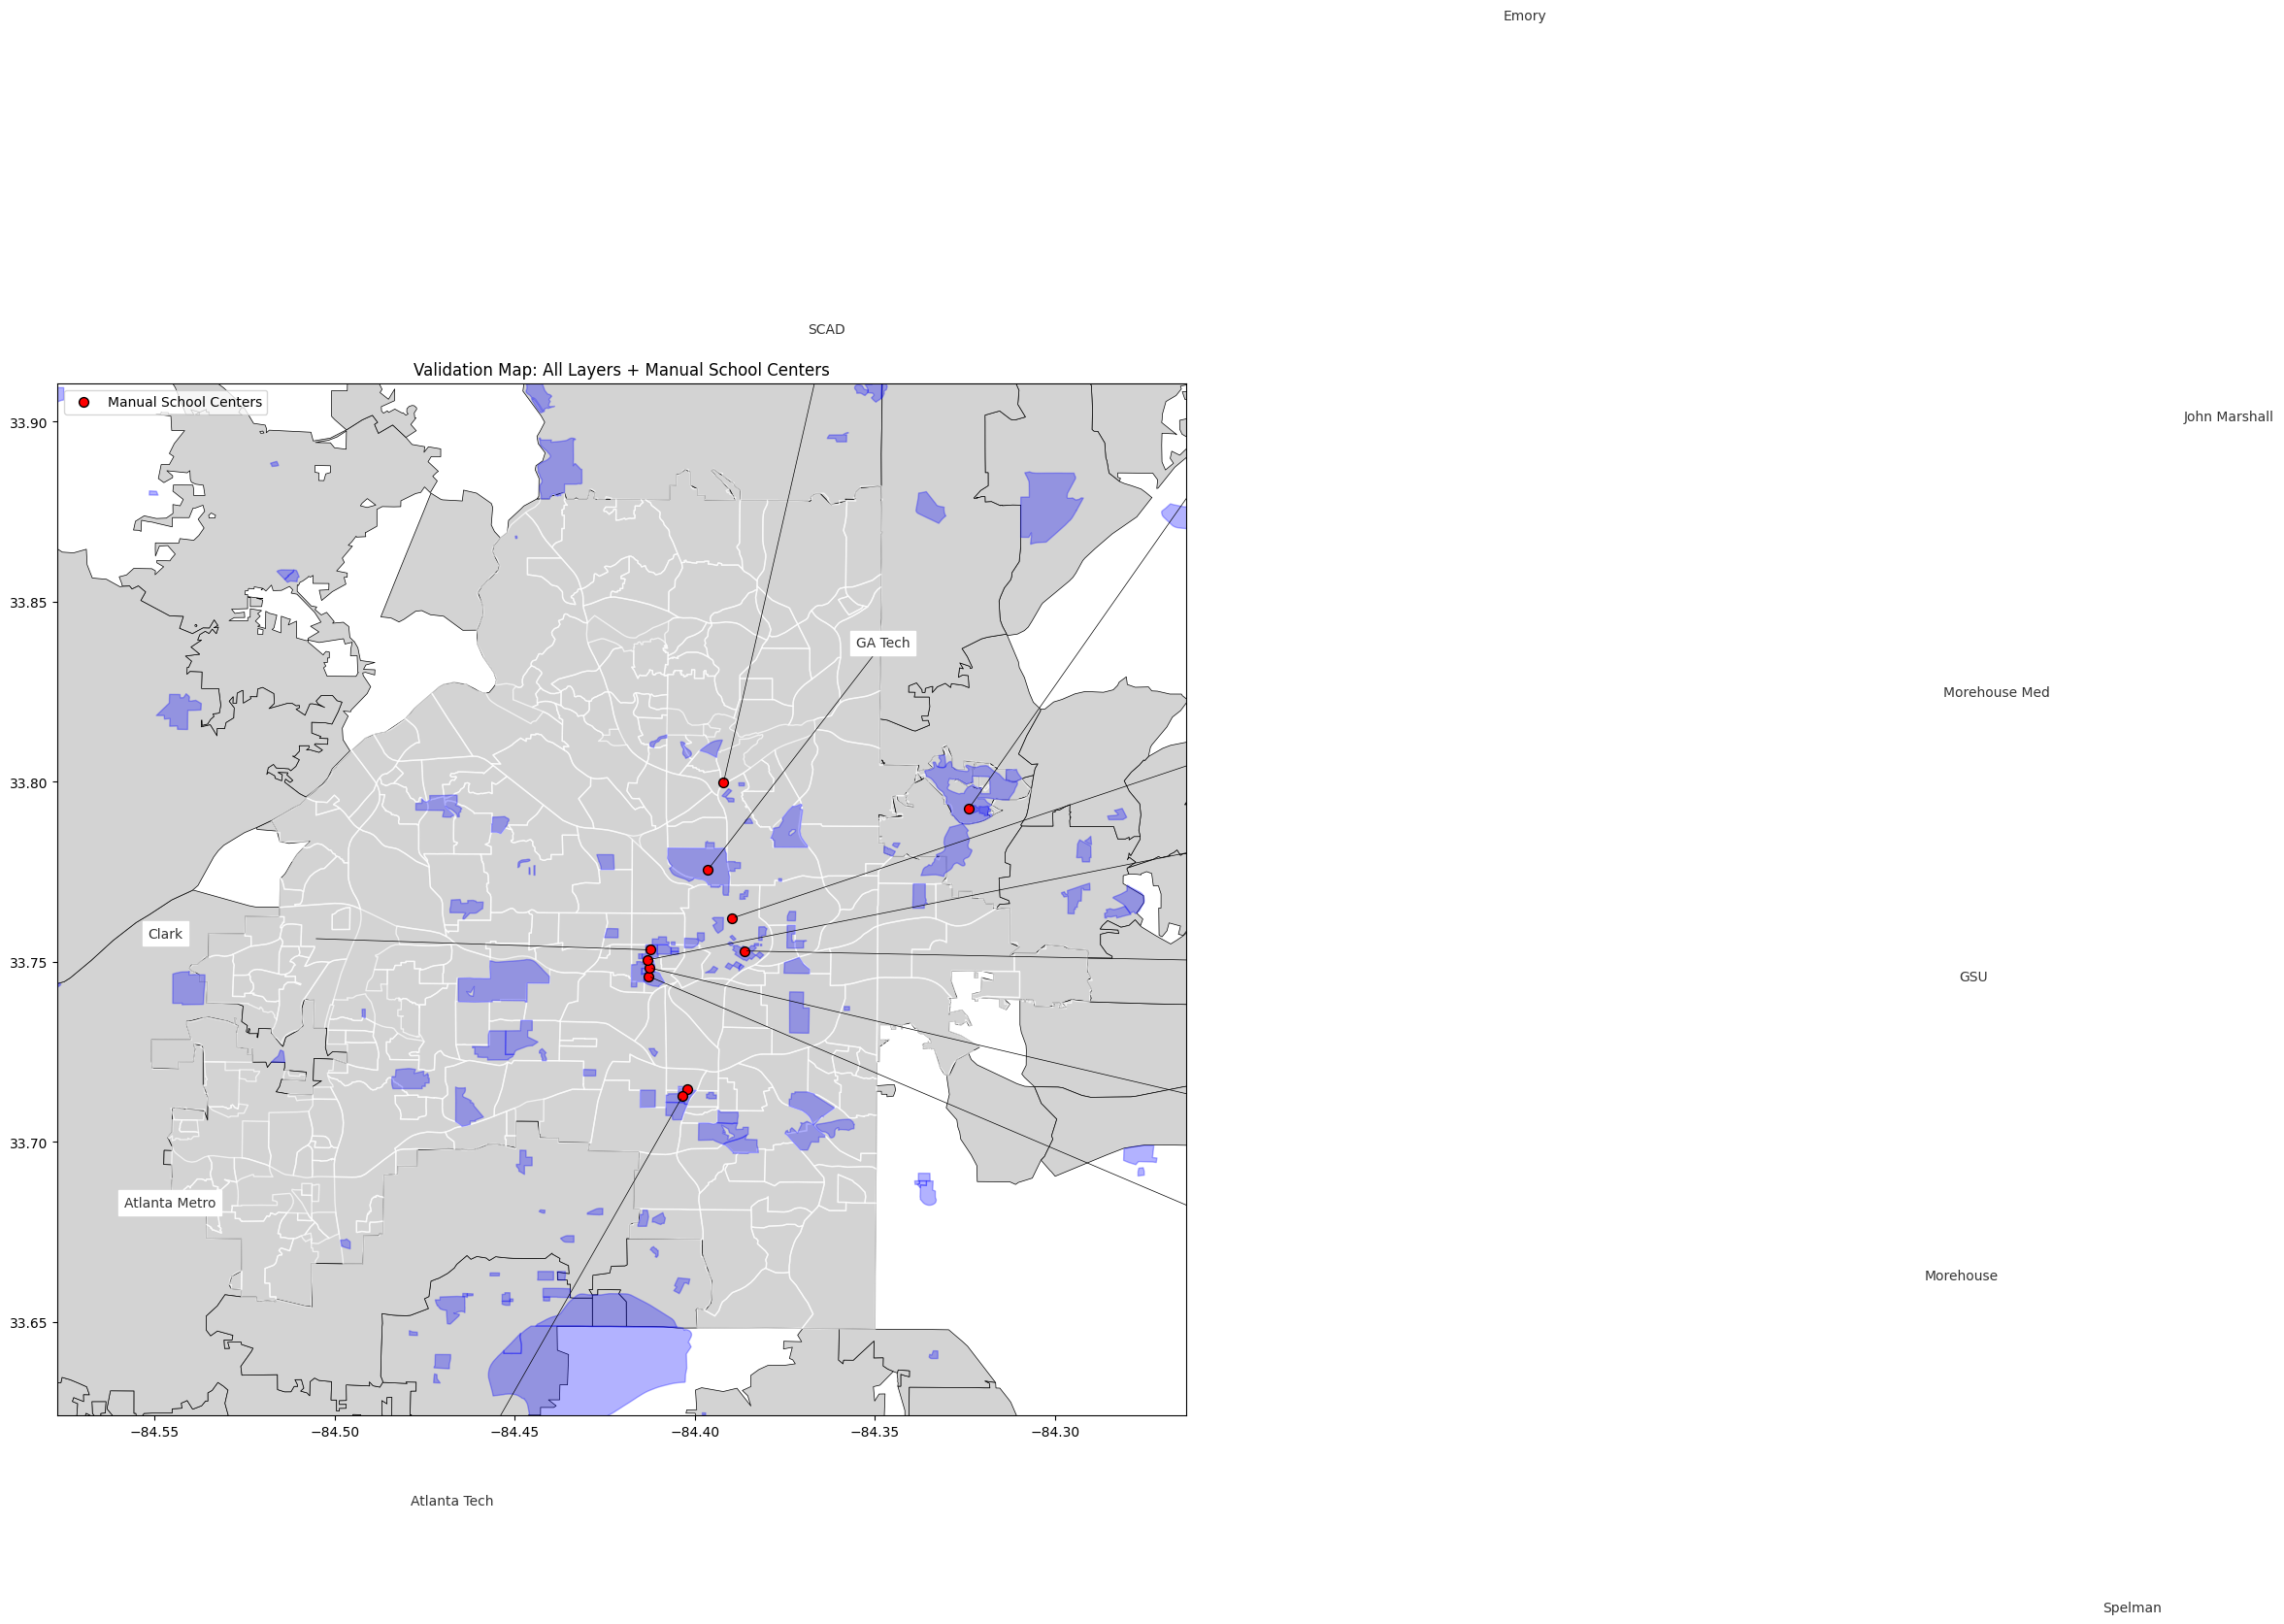

In [19]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from adjustText import adjust_text

# --- 1. DEFINE YOUR SCHOOL ACRONYMS ---
school_acronyms = {
    'GSU': (33.7530, -84.3863),
    'GA Tech': (33.7756, -84.3963),
    'Emory': (33.7925, -84.3239),
    'Clark': (33.7533, -84.4124),
    'Spelman': (33.7460, -84.4129),
    'Morehouse': (33.7483, -84.4126),
    'Morehouse Med': (33.7505, -84.4131),
    'Atlanta Metro': (33.7145, -84.4020),
    'Atlanta Tech': (33.7126, -84.4034),
    'SCAD': (33.7997, -84.3920),
    'John Marshall': (33.7621, -84.3896)
}

# --- 2. LOAD SHAPEFILES & CONVERT POINTS (Same as before) ---
# (Assuming 'cities', 'campuses', 'neighborhoods' are loaded)

df_schools = pd.DataFrame(school_acronyms.items(), columns=['School', 'Coordinates'])
df_schools['geometry'] = [Point(lon, lat) for lat, lon in df_schools['Coordinates']]
gdf_schools = gpd.GeoDataFrame(df_schools, geometry='geometry', crs="EPSG:4326")

# --- 3. ALIGN ALL CRS (Same as before) ---
target_crs = cities.crs
cities = cities.to_crs(target_crs)
campuses = campuses.to_crs(target_crs)
neighborhoods = neighborhoods.to_crs(target_crs)
gdf_schools = gdf_schools.to_crs(target_crs)

# --- 4. PLOT EVERYTHING ---
print("Creating cleaner validation map...")
fig, ax = plt.subplots(figsize=(15, 15))

# Layer 1: Cities (Gray base)
cities.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5, label='City Boundaries')
# Layer 2: Neighborhoods (White outlines)
neighborhoods.plot(ax=ax, color='none', edgecolor='white', linewidth=1.0, alpha=0.7, label='Neighborhoods')
# Layer 3: Flawed Census shapes (Blue blobs)
campuses.plot(ax=ax, color='blue', edgecolor='blue', alpha=0.3, label='Census "Landmark" Shapes')

# --- 5. UPDATED PLOT: PLOT SCHOOLS AS DOTS (No stars) ---
gdf_schools.plot(
    ax=ax,
    color='red',
    marker='o',  # <-- Use a circle marker
    markersize=50,  # <-- Make it smaller
    edgecolor='black',
    label='Manual School Centers'
)

# --- 6. FIX ASPECT RATIO (Same as before) ---
ax.set_aspect('equal')

# --- 7. ADD NON-OVERLAPPING LABELS (Same as before) ---
print("Adjusting labels...")
texts = []
for x, y, label in zip(gdf_schools.geometry.x, gdf_schools.geometry.y, gdf_schools['School']):
    texts.append(ax.text(x, y, label, backgroundcolor="white", alpha=0.8, fontsize=10))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

# --- 8. ZOOM & STYLE (Same as before) ---
atlanta_shape = cities[cities['NAME'] == 'Atlanta']
minx, miny, maxx, maxy = atlanta_shape.total_bounds
ax.set_xlim(minx - (maxx-minx)*0.1, maxx + (maxx-minx)*0.1)
ax.set_ylim(miny - (maxy-miny)*0.1, maxy + (maxy-miny)*0.1)

ax.set_title("Validation Map: All Layers + Manual School Centers")
ax.legend(loc='upper left')
plt.show()

Loading base map files...
Converting 19120 crime points...
Aligning all layers to CRS: NAD83...
Plotting all crime points by location label...


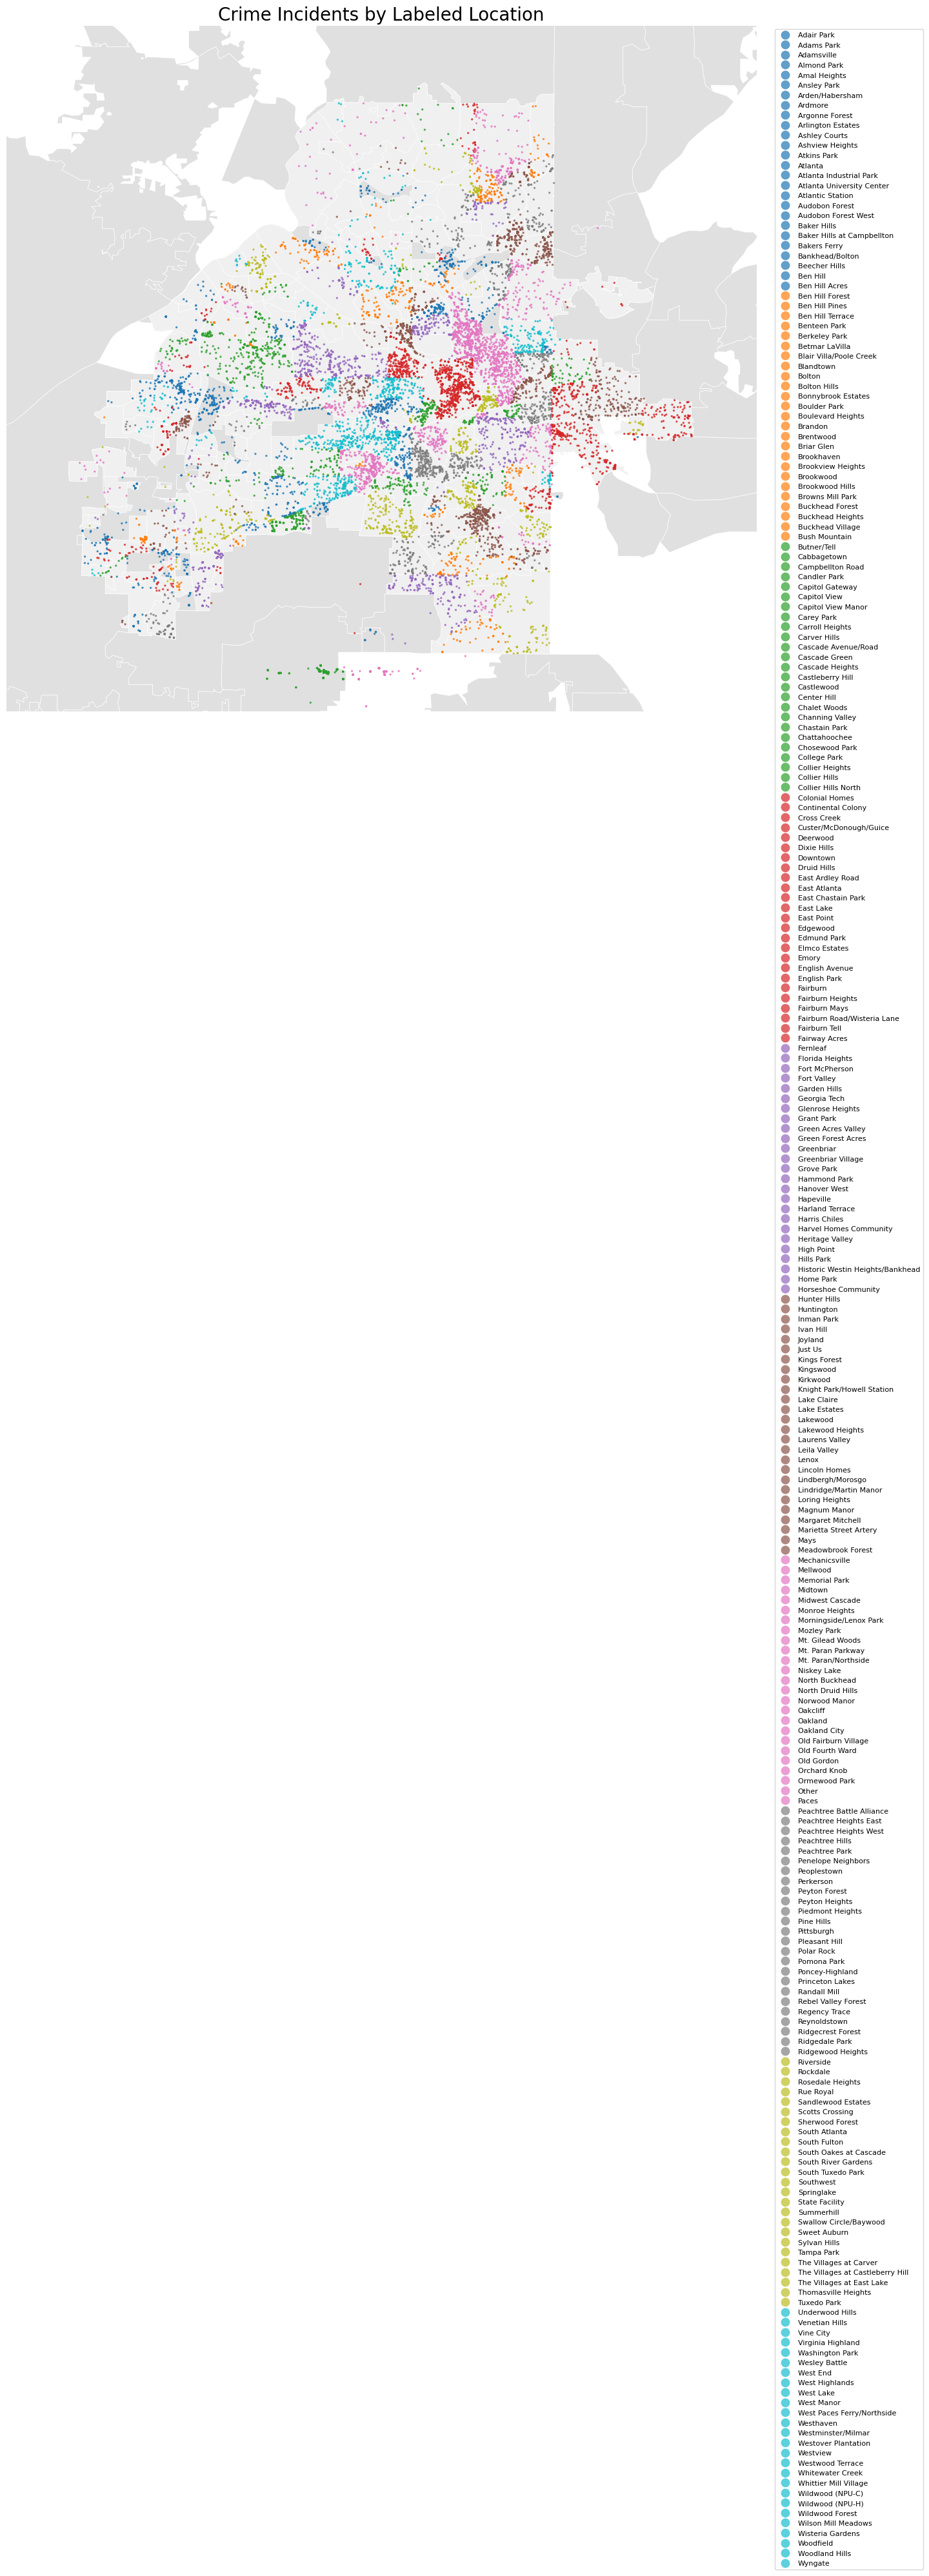

In [20]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. LOAD YOUR FINAL, CLEANED CRIME DATA ---
# Use the CSV file that has your new 'location_label'
crime_csv_path = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/eda/eda_v5/cleaned_full_atl_v5.csv"
final_df = pd.read_csv(crime_csv_path)

# --- 2. LOAD YOUR BASEMAP SHAPEFILES (Keep it simple) ---
cities_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/census_boundary_2024/cb_2024_13_place_500k.shp"
og_nhood_shp = "/workspaces/campus-burglary-risk-prediction/data/november_eda/pina_cleaned/shape_files/atl_neighborhood/Official_Neighborhoods_-_Open_Data.shp"

print("Loading base map files...")
cities = gpd.read_file(cities_shp)
neighborhoods = gpd.read_file(og_nhood_shp)

# --- 3. CONVERT YOUR CRIME DATA TO A GeoDataFrame ---
print(f"Converting {len(final_df)} crime points...")
# Make sure your Longitude/Latitude column names are correct!
gdf_crime = gpd.GeoDataFrame(
    final_df,
    geometry=gpd.points_from_xy(final_df.Longitude, final_df.Latitude),
    crs="EPSG:4326" # Start with lat/lon
)

# --- 4. ALIGN ALL CRS (Critical!) ---
target_crs = cities.crs
print(f"Aligning all layers to CRS: {target_crs.name}...")
gdf_crime = gdf_crime.to_crs(target_crs)
cities = cities.to_crs(target_crs)
neighborhoods = neighborhoods.to_crs(target_crs)

# --- 5. PLOT THE *REAL* MAP ---
print("Plotting all crime points by location label...")
fig, ax = plt.subplots(figsize=(15, 15))

# Layer 1: Plot cities as the absolute base (light gray)
cities.plot(ax=ax, color='#E0E0E0', edgecolor='white', linewidth=0.5)

# Layer 2: Plot neighborhood outlines on top (darker gray)
neighborhoods.plot(ax=ax, color='#F0F0F0', edgecolor='white', linewidth=0.5)

# Layer 3: Plot your CRIME DATA, colored by label
gdf_crime.plot(
    ax=ax,
    column='location_label',  # <-- The magic is here
    categorical=True,         # Use distinct colors
    markersize=2,             # Make points small
    alpha=0.7,                # Add transparency
    legend=True,              # Show the key
    legend_kwds={
        'loc': 'upper left', 
        'bbox_to_anchor': (1.02, 1), # Put legend outside plot
        'fontsize': 8
    }
)

# --- 6. CLEAN UP THE MAP ---
ax.set_aspect('equal') # Fix the "janky" stretching

# Zoom in on Atlanta
atlanta_shape = cities[cities['NAME'] == 'Atlanta']
minx, miny, maxx, maxy = atlanta_shape.total_bounds
ax.set_xlim(minx - (maxx-minx)*0.1, maxx + (maxx-minx)*0.1)
ax.set_ylim(miny - (maxy-miny)*0.1, maxy + (maxy-miny)*0.1)

ax.set_title("Crime Incidents by Labeled Location", fontsize=20)
ax.axis('off') # Hide the ugly axes
plt.show()